# Import Relevant Libraries and Load The Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [2]:
train = pd.read_csv(r'C:\Users\Abuyuwa\Desktop\DATASETS\data-science-nigeria-ai-in-citie\train.csv')
test = pd.read_csv(r'C:\Users\Abuyuwa\Desktop\DATASETS\data-science-nigeria-ai-in-citie\test.csv')
sample_submission = pd.read_csv(r'C:\Users\Abuyuwa\Desktop\DATASETS\data-science-nigeria-ai-in-citie\sample_submission.csv')

# Basic Exploratory  Data Analysis and Pre-Processing

In [3]:
train.head()

,traveller_ID,ticket_class,name,sex,age,Siblings_spouses,Parchil,TickNum,fare,cabin,embarked,MedBoat,Survived
0,1214,3,"Smiljanic, Mr. Mile",male,NaN,0,0,315037,8.6625,NaN,S,NaN,0
1,677,3,"Bostandyeff, Mr. Guentcho",male,26.0,0,0,349224,7.8958,NaN,S,NaN,0
2,534,2,"Phillips, Miss. Kate Florence (""Mrs Kate Louis...",female,19.0,0,0,250655,26.0000,NaN,S,11,1
3,1174,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S,NaN,0
4,864,3,"Henriksson, Miss. Jenny Lovisa",female,28.0,0,0,347086,7.7750,NaN,S,NaN,0


In [4]:
### Extract The Titles from the name column

train['Title'] = train['name'].str.extract(r', (\w+\.)')
test['Title'] = test['name'].str.extract(r', (\w+\.)')

In [5]:
### Determine the Target Variable

target = [col for col in train.columns if col not in test.columns]
target

['Survived']

In [6]:
### Find Missing Values

train.isna().sum()

traveller_ID          0
ticket_class          0
name                  0
sex                   0
age                 187
Siblings_spouses      0
Parchil               0
TickNum               0
fare                  1
cabin               712
embarked              1
MedBoat             589
Survived              0
Title                 1
dtype: int64

In [7]:
### Determining the Categorical Features
cat_feat = [feat for feat in train.columns if train[feat].dtype == 'object']
cat_feat

['name', 'sex', 'TickNum', 'cabin', 'embarked', 'MedBoat', 'Title']

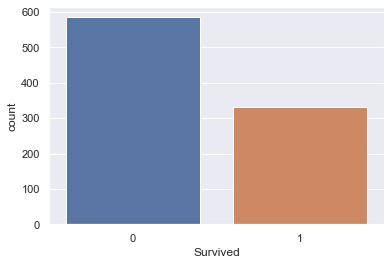

In [8]:
### Knowing The Count of Survived and Non-Survived
sns.countplot(train.Survived)

In [9]:
### Determining The numerical features
num_feat = [feat for feat in train.columns if feat not in cat_feat]
num_feat

['traveller_ID',
 'ticket_class',
 'age',
 'Siblings_spouses',
 'Parchil',
 'fare',
 'Survived']

In [10]:
## Adding Some Categorical Features to the Numerical ones 
num_feat.append('sex')
num_feat.append('embarked')
num_feat.append('MedBoat')
num_feat.append('Title')
num_feat.append('TickNum')
num_feat.append('cabin')
train.columns

Index(['traveller_ID', 'ticket_class', 'name', 'sex', 'age',
       'Siblings_spouses', 'Parchil', 'TickNum', 'fare', 'cabin', 'embarked',
       'MedBoat', 'Survived', 'Title'],
      dtype='object')

In [11]:
## Dropping The Irrelevant columns
train_x = train.drop(train[['traveller_ID', 'name',
       'Survived']], axis = 1)
test_x = test.drop(test[['traveller_ID', 'name']], axis = 1)
train_x.head()

,ticket_class,sex,age,Siblings_spouses,Parchil,TickNum,fare,cabin,embarked,MedBoat,Title
0,3,male,NaN,0,0,315037,8.6625,NaN,S,NaN,Mr.
1,3,male,26.0,0,0,349224,7.8958,NaN,S,NaN,Mr.
2,2,female,19.0,0,0,250655,26.0000,NaN,S,11,Miss.
3,3,female,NaN,8,2,CA. 2343,69.5500,NaN,S,NaN,Miss.
4,3,female,28.0,0,0,347086,7.7750,NaN,S,NaN,Miss.


In [12]:
#Mapping the Medboat and Cabin columns to input 0 where there are missing values, and 1 where there are no missing values

train_x['MedBoat_ind'] = np.where(train_x['MedBoat'].isnull(),0,1)
test_x['MedBoat_ind'] = np.where(test_x['MedBoat'].isnull(),0,1)
train_x['cabin'] = np.where(train_x['cabin'].isnull(),0,1)
test_x['cabin'] = np.where(test_x['cabin'].isnull(),0,1)
train_x['cabin'] = train_x['cabin'].astype(int)
test_x['cabin'] = test_x['cabin'].astype(int)
train_x.head(20)
train_x.columns

Index(['ticket_class', 'sex', 'age', 'Siblings_spouses', 'Parchil', 'TickNum',
       'fare', 'cabin', 'embarked', 'MedBoat', 'Title', 'MedBoat_ind'],
      dtype='object')

In [13]:
# Dropping the Initial Medboat column
train_x = train_x.drop(train_x[['MedBoat']], axis = 1)
test_x = test_x.drop(test_x[['MedBoat']], axis = 1)

In [14]:
# Finding The mode of each column with missing values and filling it up
mode_age = np.round(train_x.age.mode())
mode_age

0    24.0
dtype: float64

In [15]:
fare_mode = train_x.fare.mode()
fare_mode = (train_x.fare.mode()[0] + train_x.fare.mode()[1])/ 2
fare_mode

17.025

In [16]:
train_x.embarked.mode()
train_x.Title.mode()

0    Mr.
dtype: object

In [17]:
train_x.age.fillna('24', inplace=True)
test_x.age.fillna('24', inplace=True)
train_x.Title.fillna('Mr.', inplace=True)
test_x.Title.fillna('Mr.', inplace=True)
train_x.embarked.fillna('S', inplace = True)
test_x.embarked.fillna('S', inplace = True)
train_x.fare.fillna('17.025', inplace = True)
test_x.fare.fillna('17.025', inplace = True)

In [18]:
train_x.columns

Index(['ticket_class', 'sex', 'age', 'Siblings_spouses', 'Parchil', 'TickNum',
       'fare', 'cabin', 'embarked', 'Title', 'MedBoat_ind'],
      dtype='object')

In [19]:
trainer = pd.get_dummies(train_x[['ticket_class', 'sex', 'Siblings_spouses', 'Parchil', 'embarked', 'MedBoat_ind']])
tester = pd.get_dummies(test_x[['ticket_class', 'sex', 'Siblings_spouses', 'Parchil', 'embarked','MedBoat_ind']])

In [20]:
trainer['cabin'] = train_x['cabin']
tester['cabin'] = test_x['cabin']
trainer['ticknum'] = train_x['TickNum']
tester['ticknum'] = test_x['TickNum']
trainer['fare'] = train_x['fare']
tester['fare'] = test_x['fare']

In [21]:
trainer.shape, tester.shape

((916, 12), (393, 12))

In [22]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()
Title_enc = enc.fit_transform(train_x['Title'])
Title_enc_test = enc.fit_transform(test_x['Title'])
tick_enc = enc.fit_transform(train_x['TickNum'])
tick_enc_test = enc.fit_transform(test_x['TickNum'])

In [23]:
trainer['Title_enc'] = Title_enc
tester['Title_enc'] = Title_enc_test
trainer['age'] = train_x.age
tester['age'] = test_x.age
trainer['ticknum'] = tick_enc
tester['ticknum'] = tick_enc_test

In [24]:
trainer

,ticket_class,Siblings_spouses,Parchil,MedBoat_ind,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,cabin,ticknum,fare,Title_enc,age
0,3,0,0,0,0,1,0,0,1,0,263,8.6625,10,24
1,3,0,0,0,0,1,0,0,1,0,385,7.8958,10,26
2,2,0,0,1,1,0,0,0,1,0,173,26,7,19
3,3,8,2,0,1,0,0,0,1,0,584,69.55,7,24
4,3,0,0,0,1,0,0,0,1,0,351,7.775,7,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,3,0,0,0,1,0,0,1,0,0,290,7.6292,7,24
912,3,0,0,0,1,0,0,0,1,0,352,7.775,7,18
913,3,0,0,0,0,1,0,0,1,0,515,16.1,10,28.5
914,3,0,0,0,1,0,0,0,1,0,684,7.925,7,26


In [25]:
trainer = trainer.drop(['fare'], axis = 1)
tester = tester.drop(['fare'], axis = 1)

In [26]:
tester.head()

,ticket_class,Siblings_spouses,Parchil,MedBoat_ind,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,cabin,ticknum,Title_enc,age
0,3.0,0.0,0.0,0,0,1,0,0,1,0,332,7,35
1,3.0,1.0,1.0,1,0,1,1,0,0,0,96,7,20
2,3.0,0.0,0.0,0,0,1,0,0,1,0,187,7,24
3,3.0,0.0,0.0,0,0,1,0,0,1,0,255,7,24
4,3.0,0.0,0.0,0,0,1,0,1,0,0,229,7,24


In [27]:
scaler = StandardScaler()
cols = trainer.columns
x = scaler.fit_transform(trainer)
testing = scaler.fit_transform(tester)
x = pd.DataFrame(data = x, columns = cols)
testing = pd.DataFrame(data = testing, columns = cols)
testing.head()

,ticket_class,Siblings_spouses,Parchil,MedBoat_ind,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,cabin,ticknum,Title_enc,age
0,0.882021,-0.433273,-0.479750,-0.824310,-0.752155,0.752155,-0.517438,-0.302765,0.647126,-0.54893,1.566752,0.346208,0.338808
1,0.882021,0.637647,0.777195,1.213136,-0.752155,0.752155,1.932599,-0.302765,-1.545293,-0.54893,-0.760753,0.346208,-0.717439
2,0.882021,-0.433273,-0.479750,-0.824310,-0.752155,0.752155,-0.517438,-0.302765,0.647126,-0.54893,0.136717,0.346208,-0.435773
3,0.882021,-0.433273,-0.479750,-0.824310,-0.752155,0.752155,-0.517438,-0.302765,0.647126,-0.54893,0.807354,0.346208,-0.435773
4,0.882021,-0.433273,-0.479750,-0.824310,-0.752155,0.752155,-0.517438,3.302891,-1.545293,-0.54893,0.550934,0.346208,-0.435773


In [28]:
testing

,ticket_class,Siblings_spouses,Parchil,MedBoat_ind,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,cabin,ticknum,Title_enc,age
0,0.882021,-0.433273,-0.479750,-0.824310,-0.752155,0.752155,-0.517438,-0.302765,0.647126,-0.54893,1.566752,0.346208,0.338808
1,0.882021,0.637647,0.777195,1.213136,-0.752155,0.752155,1.932599,-0.302765,-1.545293,-0.54893,-0.760753,0.346208,-0.717439
2,0.882021,-0.433273,-0.479750,-0.824310,-0.752155,0.752155,-0.517438,-0.302765,0.647126,-0.54893,0.136717,0.346208,-0.435773
3,0.882021,-0.433273,-0.479750,-0.824310,-0.752155,0.752155,-0.517438,-0.302765,0.647126,-0.54893,0.807354,0.346208,-0.435773
4,0.882021,-0.433273,-0.479750,-0.824310,-0.752155,0.752155,-0.517438,3.302891,-1.545293,-0.54893,0.550934,0.346208,-0.435773
...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,-0.325764,-0.433273,-0.479750,-0.824310,-0.752155,0.752155,-0.517438,-0.302765,0.647126,-0.54893,-0.888963,0.346208,-0.013274
389,0.882021,-0.433273,-0.479750,-0.824310,-0.752155,0.752155,1.932599,-0.302765,-1.545293,-0.54893,-0.642405,0.346208,-0.823064
390,-0.325764,-0.433273,-0.479750,-0.824310,-0.752155,0.752155,-0.517438,-0.302765,0.647126,-0.54893,-1.086209,1.956384,0.761307
391,0.882021,-0.433273,-0.479750,1.213136,1.329513,-1.329513,-0.517438,-0.302765,0.647126,-0.54893,-0.247913,-1.263967,-0.435773


In [29]:
### Splitting the data into train and test
x_train, x_test, y_train, y_test = train_test_split(x, train.Survived, test_size=0.2, random_state=42)

In [30]:
x_train

,ticket_class,Siblings_spouses,Parchil,MedBoat_ind,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,cabin,ticknum,Title_enc,age
25,-1.551881,0.425943,0.686709,-0.745103,-0.739795,0.739795,-0.506474,-0.330089,0.658399,-0.535273,0.609157,0.406421,2.309197
84,0.825248,-0.498616,-0.432553,-0.745103,-0.739795,0.739795,1.974436,-0.330089,-1.518835,-0.535273,0.221359,0.406421,0.394130
10,-0.363317,-0.498616,-0.432553,-0.745103,-0.739795,0.739795,-0.506474,-0.330089,0.658399,-0.535273,-0.864475,0.406421,1.910225
797,0.825248,-0.498616,-0.432553,-0.745103,-0.739795,0.739795,-0.506474,-0.330089,0.658399,-0.535273,1.554415,0.406421,-0.324020
451,-1.551881,0.425943,-0.432553,1.342097,1.351725,-1.351725,-0.506474,-0.330089,0.658399,1.868207,-1.213493,0.955510,0.553719
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,-1.551881,0.425943,-0.432553,1.342097,1.351725,-1.351725,1.974436,-0.330089,-1.518835,1.868207,-1.378308,0.955510,-0.722992
270,0.825248,-0.498616,-0.432553,-0.745103,-0.739795,0.739795,-0.506474,-0.330089,0.658399,-0.535273,0.444343,0.406421,1.271869
860,0.825248,-0.498616,-0.432553,-0.745103,-0.739795,0.739795,1.974436,-0.330089,-1.518835,-0.535273,-0.641491,0.406421,-0.324020
435,0.825248,-0.498616,-0.432553,1.342097,1.351725,-1.351725,-0.506474,-0.330089,0.658399,-0.535273,0.085630,-1.240844,-0.962375


# Data Modelling

In [31]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(x_train,y_train)

C:\Users\yuwa\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
pred = classifier.predict(x_test)
pred2 = classifier.predict(x_train)

In [33]:
f1_score(y_train,pred2)

0.967984934086629

In [34]:
f1_score(y_test,pred)

0.9763779527559054

In [35]:
sample_submission.head()

,traveller_ID,Survived
0,1148,0
1,1049,1
2,982,0
3,808,1
4,1195,0


In [36]:
submissionfile = sample_submission.copy()

In [37]:
submissionfile.Survived = classifier.predict(tester)
submissionfile

,traveller_ID,Survived
0,1148,0
1,1049,0
2,982,0
3,808,0
4,1195,0
...,...,...
388,325,0
389,919,0
390,532,0
391,1159,0


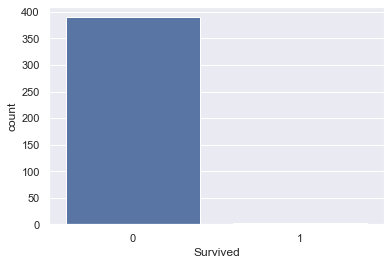

In [38]:
sns.countplot(submissionfile.Survived)

In [39]:
submissionfile.to_csv('Yuwas Logistic Regression submission', index = False)

In [40]:
classifier.predict(tester)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [41]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [42]:
pred_dtc = dtc.predict(x_test)
pred2_dtc = dtc.predict(x_train)
f1_score(y_train,pred2_dtc)

1.0

In [43]:
f1_score(y_test,pred_dtc)

0.9606299212598425

In [44]:
test_predict = dtc.predict(testing)

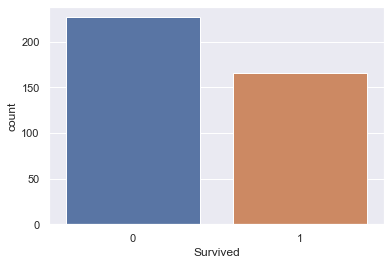

In [45]:
submissionfile2 = sample_submission.copy()
submissionfile2['Survived'] = test_predict
submissionfile2
sns.countplot(submissionfile2.Survived)

In [46]:
submissionfile2.to_csv('Yuwas Decision Tree Classifier submission.csv', index = False)

In [47]:
pd.options.display.max_rows = None
submissionfile2

,traveller_ID,Survived
0,1148,0
1,1049,1
2,982,0
3,808,0
4,1195,0
5,240,1
6,1118,0
7,596,1
8,924,0
9,65,1


In [48]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train,y_train)

C:\Users\yuwa\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [49]:
pred_rfc = rfc.predict(x_test)
pred2_rfc = rfc.predict(x_train)
f1_score(y_train,pred2_rfc)

0.9943714821763602

In [50]:
f1_score(y_test,pred_rfc)

0.984375

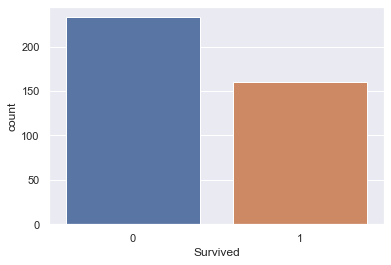

In [51]:
submissionfile3 = sample_submission.copy()
submissionfile3['Survived'] = rfc.predict(testing)
submissionfile2
sns.countplot(submissionfile3.Survived)
submissionfile2.to_csv('Yuwas Random Forest submission.csv', index = False)

In [52]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [53]:
pred_gnb = gnb.predict(x_test)
pred2_gnb = gnb.predict(x_train)
f1_score(y_train,pred2_gnb)

0.967984934086629

In [54]:
f1_score(y_test,pred_gnb)

0.9763779527559054

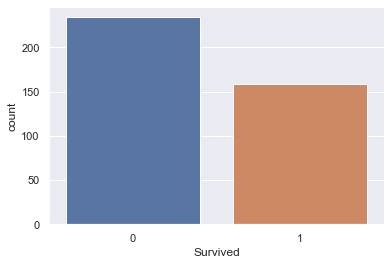

In [55]:
submissionfile3 = sample_submission.copy()
submissionfile3['Survived'] = gnb.predict(testing)
submissionfile2
sns.countplot(submissionfile3.Survived)
submissionfile2.to_csv('Yuwas Naive Bayes submission.csv', index = False)

In [56]:
from xgboost import XGBClassifier

In [57]:
xgcl = XGBClassifier()
xgcl.fit(x_train, y_train)
pred_xgcl = xgcl.predict(x_test)
pred2_xgcl = xgcl.predict(x_train)
f1_score(y_train,pred2_xgcl)

0.9831775700934579

In [58]:
f1_score(y_test,pred_xgcl)

0.96875

In [59]:
x

,ticket_class,Siblings_spouses,Parchil,MedBoat_ind,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,cabin,ticknum,Title_enc,age
0,0.825248,-0.498616,-0.432553,-0.745103,-0.739795,0.739795,-0.506474,-0.330089,0.658399,-0.535273,-0.408813,0.406421,-0.324020
1,0.825248,-0.498616,-0.432553,-0.745103,-0.739795,0.739795,-0.506474,-0.330089,0.658399,-0.535273,0.182579,0.406421,-0.164431
2,-0.363317,-0.498616,-0.432553,1.342097,1.351725,-1.351725,-0.506474,-0.330089,0.658399,-0.535273,-0.845085,-1.240844,-0.722992
3,0.825248,6.897852,1.805972,-0.745103,1.351725,-1.351725,-0.506474,-0.330089,0.658399,-0.535273,1.147227,-1.240844,-0.324020
4,0.825248,-0.498616,-0.432553,-0.745103,1.351725,-1.351725,-0.506474,-0.330089,0.658399,-0.535273,0.017765,-1.240844,-0.004842
5,0.825248,0.425943,0.686709,1.342097,1.351725,-1.351725,-0.506474,-0.330089,0.658399,-0.535273,0.066240,-1.240844,-2.159292
6,0.825248,-0.498616,-0.432553,-0.745103,-0.739795,0.739795,-0.506474,-0.330089,0.658399,-0.535273,1.530177,0.406421,-0.324020
7,0.825248,-0.498616,-0.432553,1.342097,1.351725,-1.351725,-0.506474,3.029485,-1.518835,-0.535273,0.730344,-1.240844,0.154747
8,0.825248,-0.498616,-0.432553,-0.745103,-0.739795,0.739795,-0.506474,3.029485,-1.518835,-0.535273,-0.282778,0.406421,-0.324020
9,0.825248,-0.498616,-0.432553,-0.745103,-0.739795,0.739795,-0.506474,3.029485,-1.518835,-0.535273,-0.234303,0.406421,-0.324020


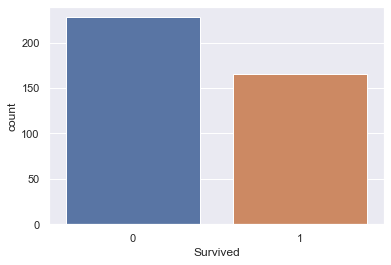

In [60]:
submissionfile3 = sample_submission.copy()
submissionfile3['Survived'] = xgcl.predict(testing)
submissionfile2
sns.countplot(submissionfile3.Survived)
submissionfile2.to_csv('Yuwas xgboost submission.csv', index = False)